In [1]:
## Mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
## Imports
import glob
from torchvision import datasets, transforms, models
from PIL import *
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, sampler
import numpy as np
import os
import time
import cv2
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import models
import sys

In [11]:
## Define paths
parentDir = F"/content/gdrive/My Drive/deep_learning/Project"
imageDir =  'IMAGES/'
path_save_model = F"/content/gdrive/My Drive/deep_learning/Project/models/"
path_save_results =  F"/content/gdrive/My Drive/deep_learning/Project/Results/"
zipped_images_path = '/content/gdrive/My Drive/deep_learning/Project/IMAGES/Zipped/'
zipped_labels_path = '/content/gdrive/My Drive/deep_learning/Project/LABELS/Zipped/'
csv_path = '/content/gdrive/My Drive/deep_learning/Project/final/results/Resultss_2class.csv'

In [4]:
#Define basic parameters
diff = [3]#[1,3] # The frame difference used to create the label
batchSize = [16] # [4,8,16,32]
zipped = 1 #load zipped folders to the current workspace - shortens run time 
num_class = [2]# 1-channel from the object, 2-one channel to the object and one for the background
lr_scheduler_op = [1] #1-ExponentialLR, 2-ReduceLROnPlateau
n_epochs = 3
print_every = 10# after a few batches, calculate valdiation scores
criterions = [nn.BCEWithLogitsLoss()]#,nn.MSELoss()] 
models_names = ['model_UNET_resnet101']#,'model_UNET_densenet161','model_UNET_xception','model_deeplabv3_resnet101']
pretrained = 1 #using pretrained model
trained_layers = 'all' 
optimizer_name = 'ADAM_0.0005'
trained_on = ['3065', '2985', '3089', '3087', '3091']
validation_set = ['3077']

In [5]:
## Import our scores and dataset builder
sys.path.append(parentDir)
import Scores as s
import dataset_builder as MyDataset

Load Data

In [7]:
if zipped:
  ## Unzip the zipped image folders
  print('Unzipping images')
  base = Path(zipped_images_path)
  for i in range(1,5):
    print(i)
    zip_path = base/f'IMAGES-20210211T164523Z-00{i}.zip'
    !cp "{zip_path}" .
  !unzip -q IMAGES-20210211T164523Z-001.zip
  !rm IMAGES-20210211T164523Z-001.zip
  !unzip -q IMAGES-20210211T164523Z-002.zip
  !rm IMAGES-20210211T164523Z-002.zip
  !unzip -q IMAGES-20210211T164523Z-003.zip
  !rm IMAGES-20210211T164523Z-003.zip
  !unzip -q IMAGES-20210211T164523Z-004.zip
  !rm IMAGES-20210211T164523Z-004.zip

  if 3 in diff:
    ## Unzip the zipped label folders (diff = 3)
    print('Unzipping labels diff = 3')
    base = Path(zipped_labels_path)
    for i in range(1,4):
      print(i)
      zip_path = base/f'Diff=3-20210212T191543Z-00{i}.zip'
      !cp "{zip_path}" .
    !unzip -q Diff=3-20210212T191543Z-001.zip
    !rm Diff=3-20210212T191543Z-001.zip
    !unzip -q Diff=3-20210212T191543Z-002.zip
    !rm Diff=3-20210212T191543Z-002.zip
    !unzip -q Diff=3-20210212T191543Z-003.zip
    !rm Diff=3-20210212T191543Z-003.zip

    print(os.listdir('/content/Diff=3/'))
    for folder in os.listdir('/content/Diff=3/'):
      dst = folder.split('_')[1]
      print(dst)
      os.rename('/content/Diff=3/' + folder, '/content/Diff=3/'+dst)
  
  if 1 in diff:
    ## Unzip the zipped label folders
    print('Unzipping labels diff = 1')
    base = Path(zipped_labels_path)
    for i in range(1,3):
      print(i)
      zip_path = base/f'Diff=1-20210212T191546Z-00{i}.zip'
      !cp "{zip_path}" .
    !unzip -q Diff=1-20210212T191546Z-001.zip
    !rm Diff=1-20210212T191546Z-001.zip
    !unzip -q Diff=1-20210212T191546Z-002.zip
    !rm Diff=1-20210212T191546Z-002.zip

Unzipping images
1
2
3
4
Unzipping labels diff = 3
1
2
3
['IMG_2985', 'IMG_3065', 'IMG_3091', 'IMG_3089', 'IMG_3087', 'IMG_3077']
2985
3065
3091
3089
3087
3077


Model

In [8]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

class HandSegModel(nn.Module):
  def __init__(self, my_pretrained_model):
      super(HandSegModel,self).__init__()
      self.dl = my_pretrained_model
      
  def forward(self, x):
      y = self.dl(x)['out']
      return y

def get_model(model_name, classes): ##model_UNET_encoder
  model_type = model_name.split('_')[1]
  encoder = model_name.split('_')[2]
  print(model_type, encoder)
  model = []
  if model_type == 'UNET':
    model = smp.Unet(encoder, encoder_weights="imagenet", classes=classes)
  elif model_type == 'deeplabv3' and encoder == 'resnet101':
    model = models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.aux_classifier[4] = nn.Conv2d(256, classes, kernel_size=(1, 1), stride=(1, 1))
    model.classifier[4] = nn.Conv2d(256, classes, kernel_size=(1, 1), stride=(1, 1))
    model = HandSegModel(my_pretrained_model=model)
  return model

     |████████████████████████████████| 71kB 3.4MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 245kB 19.8MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=71c07bb1ab8c3a7dfa004af51d080b15cf3dce944f6682cf9cf1291b9f44d1e6
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=4c808c5a7399b5991ac65eafa2da53d5072c92e57543cee7c2654aa9f99e2968
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


Save File

In [14]:
if not os.path.isfile(csv_path):
  print('Creating csv')
  dataset = pd.DataFrame(columns = ['Architecture', 'Model_name', 'pretrained',	'trained_layers',	'diff',	'epochs',
                                    'batchsize',	'num_class',	'optimizer',	'criterion', 'lr_scheduler_op', 'trained on', 
                                    'Train_MSE', 'Train_loss', 'Train_meanIOU', 'Train_pixelAcc', 'Train_dice_score',
                                    'Test_MSE', 'Test_loss', 'Test_meanIOU', 'Test_pixelAcc', 'Test_dice_score','Rest_time',])
  dataset.to_csv(csv_path)#, index = False)

In [15]:
def add_to_csv(Architecture, Model_name, pretrained, trained_layers,
               diff, epochs,	batchsize, num_class,	optimizer,	
               criterion, lr_scheduler_op, trained_on, Train_MSE, 
               Train_loss, Train_meanIOU, Train_pixelAcc, 
               Train_dice_score, Test_MSE, Test_loss, 
               Test_meanIOU, Test_pixelAcc, Test_dice_score,Rest_time):

  dataset = pd.DataFrame({'Architecture': Architecture,
                          'Model_name': Model_name, 
                          'pretrained': pretrained,	
                          'trained_layers': trained_layers,	
                          'diff': diff,	
                          'epochs': epochs,	
                          'batchsize': batchsize,	
                          'num_class': num_class,	
                          'optimizer': optimizer,	
                          'criterion': criterion,	
                          'lr_scheduler_op': lr_scheduler_op, 
                          'trained on': trained_on, 
                          'Train_MSE': Train_MSE, 
                          'Train_loss': Train_loss, 
                          'Train_meanIOU': Train_meanIOU, 
                          'Train_pixelAcc': Train_pixelAcc, 
                          'Train_dice_score': Train_dice_score,
                          'Test_MSE': Test_MSE, 
                          'Test_loss': Test_loss, 
                          'Test_meanIOU': Test_meanIOU, 
                          'Test_pixelAcc': Test_pixelAcc, 
                          'Test_dice_score': Test_dice_score,
                          'Rest_time':Rest_time}, index=[0])
  dataset.to_csv(csv_path, 
                 mode='a', header=False)

Training

In [16]:
## Check if GPU is available
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_GPU = True if torch.cuda.is_available() else False

In [17]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [18]:
def parser(model_name):
  pars = model_name.split('_')
  model_type = pars[1]
  pars2 = pars[2].split(',')
  encoder = pars2[0]
  diff = int(pars2[1].split(':')[1])
  batch_size =  int(pars2[2].split(':')[1])
  classes =  int(pars2[3].split(':')[1])
  criterion =  pars2[4].split(':')[1]
  epoch =  int(pars[4].split(':')[1][0])
  print(model_type, encoder, diff, batch_size, classes, criterion, epoch)
  return model_type, encoder, diff, batch_size, classes, criterion, epoch

In [19]:
def create_loader(diff, classes, batchSize, lis, zipped, train):
  pre = '/content/' if zipped else ''
  maskDir=f'Diff={diff}/' if zipped else f'LABELS/Diff={diff}/'

  for file_name in lis: 
      print(pre + imageDir + file_name, pre + maskDir + file_name if zipped else maskDir + file_name)
      Dataset = MyDataset.MyDataset('' if zipped else parentDir,
                                                                        pre + imageDir + file_name,
                                                                        pre + maskDir + file_name if zipped
                                                                        else maskDir + file_name, classes, diff,
                                                                        zipped)
  loader = DataLoader(Dataset, batch_size=batchSize, shuffle=True if train else False, drop_last=True)
  return loader

In [20]:
def plot_graphs(model_arch, epoch, running_train_loss, running_test_loss_arr, 
                                  meanioutrain, meanioutest_arr, 
                                  pixelacctrain, pixelacctest_arr, 
                                  dicetrain, dicetest_arr, N=1):
  fig, ax = plt.subplots(ncols = 4, nrows = 2, figsize = (20,10))
  ax[0][0].plot(running_mean(running_train_loss, N), 'r.', label='training loss')
  ax[1][0].plot(running_mean(running_test_loss_arr, N), 'b.', label='validation loss')
  ax[0][1].plot(running_mean(meanioutrain, N), 'g.', label='meanIOU training')
  ax[1][1].plot(running_mean(meanioutest_arr, N), 'r.', label='meanIOU validation')
  ax[0][2].plot(running_mean(pixelacctrain, N), 'b.', label='pixelAcc  training')
  ax[1][2].plot(running_mean(pixelacctest_arr, N), 'b.', label='pixelAcc validation')
  ax[0][3].plot(running_mean(dicetrain, N), 'b.', label='Dice  training')
  ax[1][3].plot(running_mean(dicetest_arr, N), 'b.', label='Dice validation')
  for a in ax:
      for f in a:
          f.legend()
          f.grid(True)

  plt.savefig(path_save_results+model_arch+'_'+str(epoch)+'second_BCELOSS_printevery=700_7.3-test.jpeg')
  plt.show()

In [21]:
def plot_segmentation_comparison(new_image, new_predicted):
  image = new_image[0,1,:,:].cpu().detach().numpy()
  predicted = new_predicted[0,1,:,:].cpu().detach().numpy()
  plt.figure(figsize=(15,15))
  plt.subplot(1,4,1)
  plt.imshow(image)
  plt.axis('off')
  plt.title('Original label')
  plt.subplot(1,4,2)
  plt.imshow(predicted)
  plt.axis('off')
  plt.title('Predicted')
  plt.subplot(1,4,3)
  plt.imshow(predicted > np.mean(predicted))
  plt.axis('off')
  plt.title('Predicted after threshold')
  plt.subplot(1,4,4)
  plt.imshow(image> np.mean(image))
  plt.axis('off')
  plt.title('Original after threshold')
  plt.show()

Numer of classes: 2
UNET resnet101


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



Using GPU
model:model_UNET_resnet101
Batch size is:  16
Diff is: 3
/content/IMAGES/3065 /content/Diff=3/3065
['/content/IMAGES/3065/IMG_3065_1.jpeg']
['/content/IMAGES/3065/IMG_3065_2.jpeg']
9029
9029
/content/IMAGES/2985 /content/Diff=3/2985
['/content/IMAGES/2985/IMG_2985_1.jpeg']
['/content/IMAGES/2985/IMG_2985_2.jpeg']
9034
9034
/content/IMAGES/3089 /content/Diff=3/3089
['/content/IMAGES/3089/IMG_3089_1.jpeg']
['/content/IMAGES/3089/IMG_3089_2.jpeg']
9082
9082
/content/IMAGES/3087 /content/Diff=3/3087
['/content/IMAGES/3087/IMG_3087_1.jpeg']
['/content/IMAGES/3087/IMG_3087_2.jpeg']
9083
9083
/content/IMAGES/3091 /content/Diff=3/3091
['/content/IMAGES/3091/IMG_3091_1.jpeg']
['/content/IMAGES/3091/IMG_3091_2.jpeg']
9035
9035
/content/IMAGES/3077 /content/Diff=3/3077
['/content/IMAGES/3077/IMG_3077_1.jpeg']
['/content/IMAGES/3077/IMG_3077_2.jpeg']
9078
9078
Criterion is: BCEWithLogitsLoss()
The shape of the data: torch.Size([16, 3, 256, 256])
Epoch: 1.000000, Batch:1 loss:0.682703018

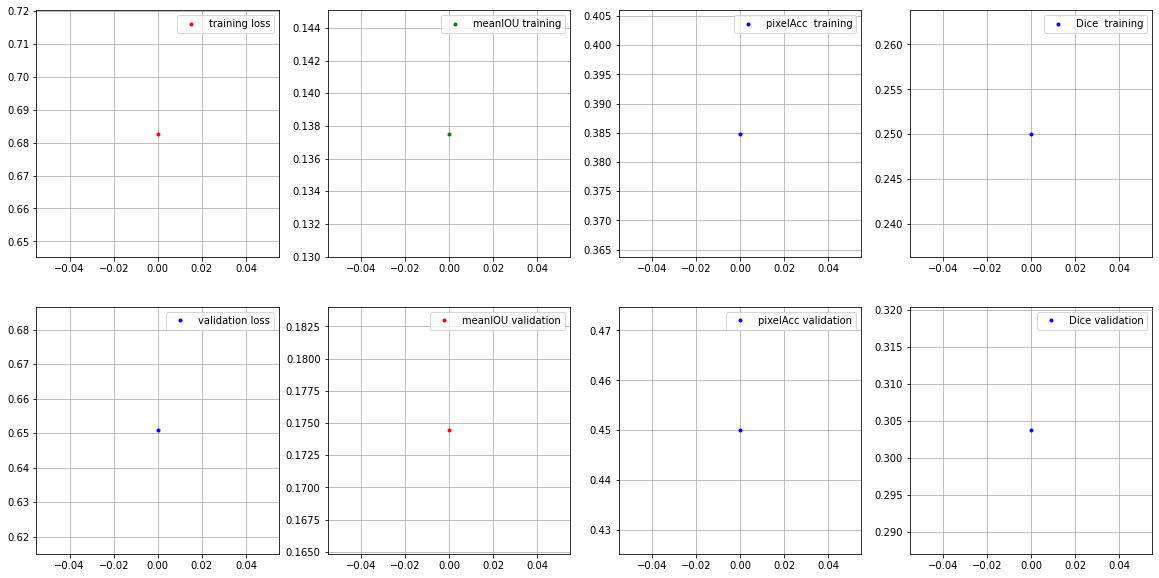

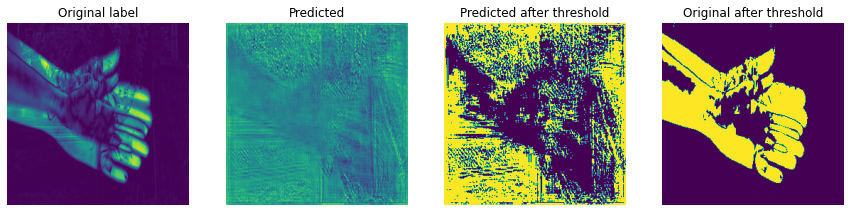

/content/gdrive/My Drive/deep_learning/Project/models/model_UNET_resnet101,Epoch:1,batch:0second_BCELOSS_print_every=700_7.3_test.pt
Epoch: 1.000000, Batch:11 loss:0.4358223378658


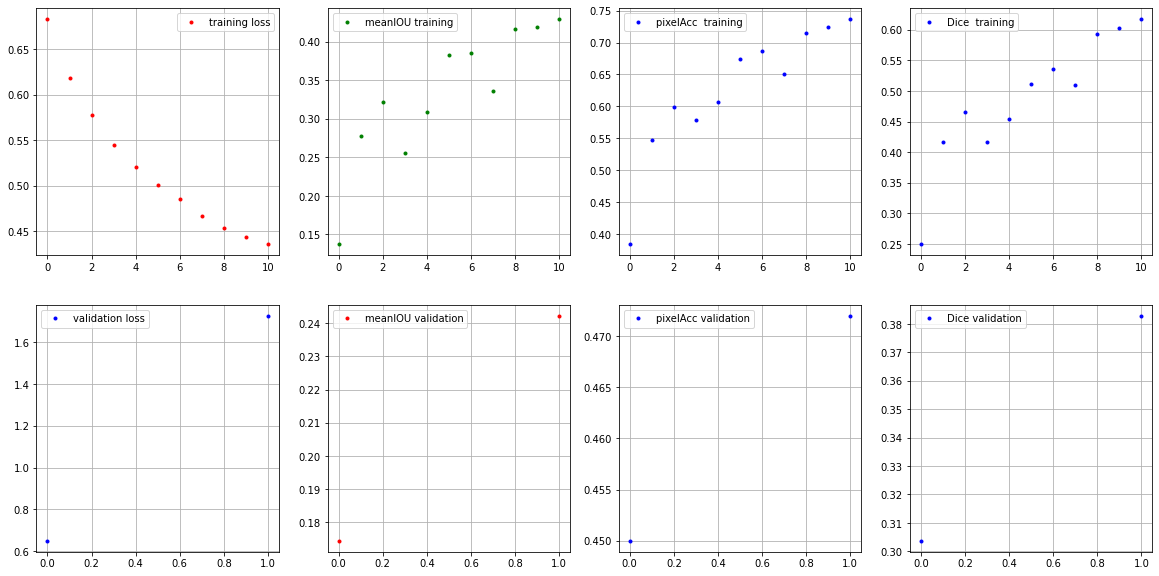

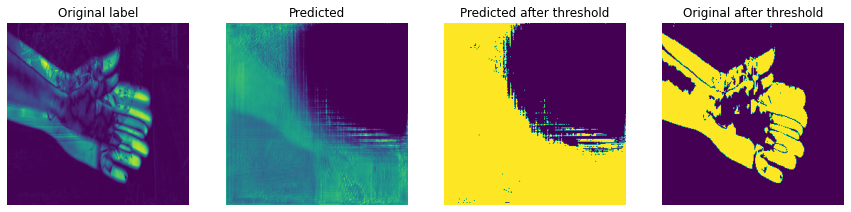

/content/gdrive/My Drive/deep_learning/Project/models/model_UNET_resnet101,Epoch:1,batch:10second_BCELOSS_print_every=700_7.3_test.pt
Epoch: 1.000000, Batch:21 loss:0.3887912929058


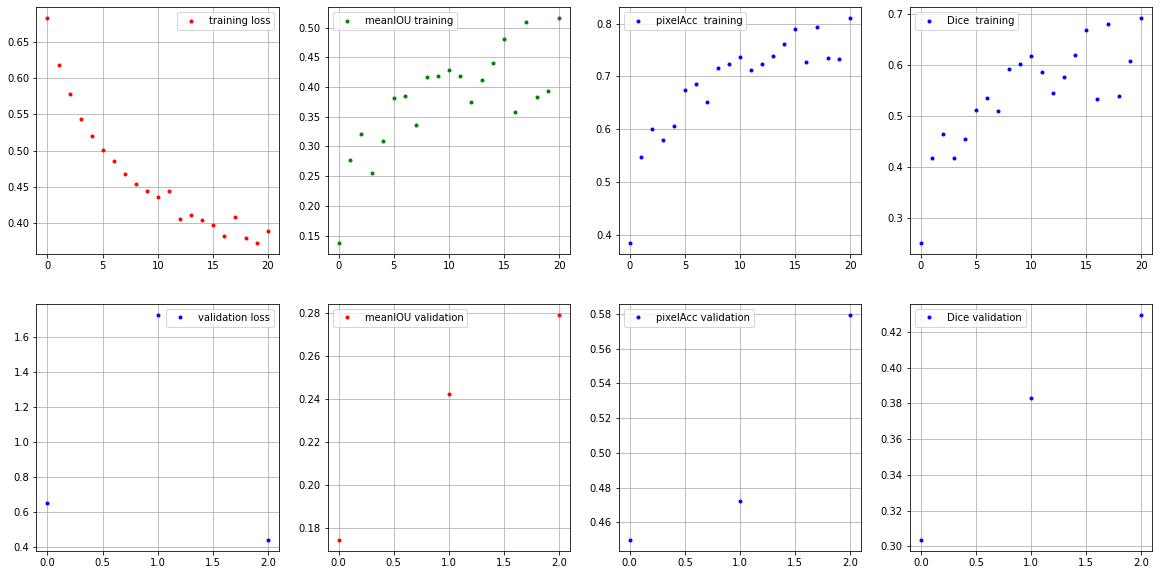

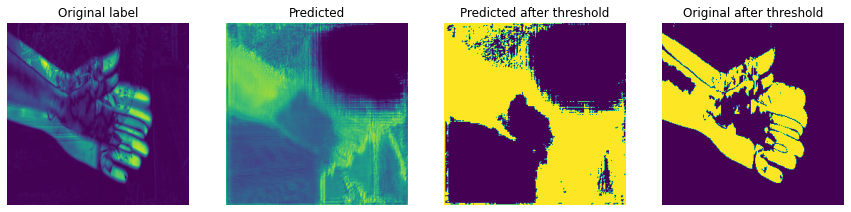

/content/gdrive/My Drive/deep_learning/Project/models/model_UNET_resnet101,Epoch:1,batch:20second_BCELOSS_print_every=700_7.3_test.pt
Epoch: 1.000000, Batch:31 loss:0.3318391144276


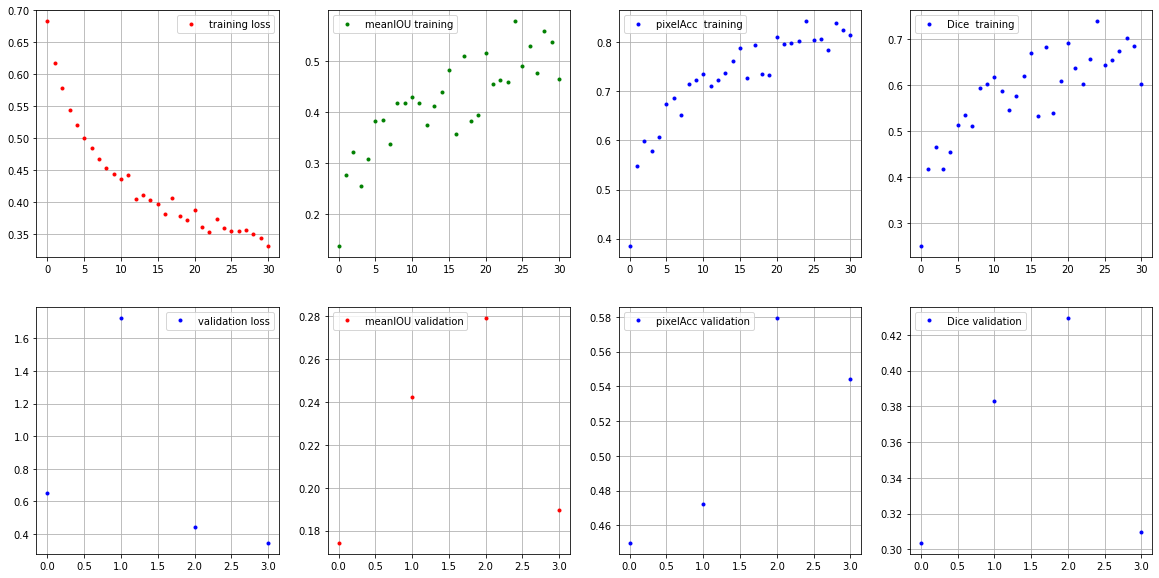

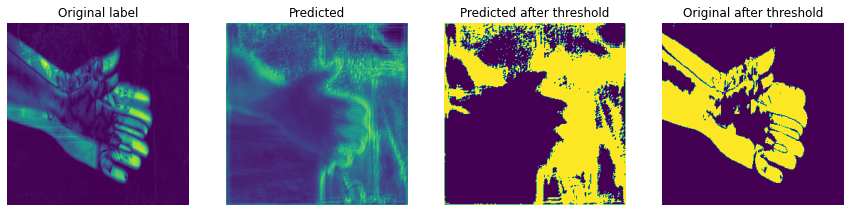

/content/gdrive/My Drive/deep_learning/Project/models/model_UNET_resnet101,Epoch:1,batch:30second_BCELOSS_print_every=700_7.3_test.pt
Epoch: 1.000000, Batch:41 loss:0.3334578573704


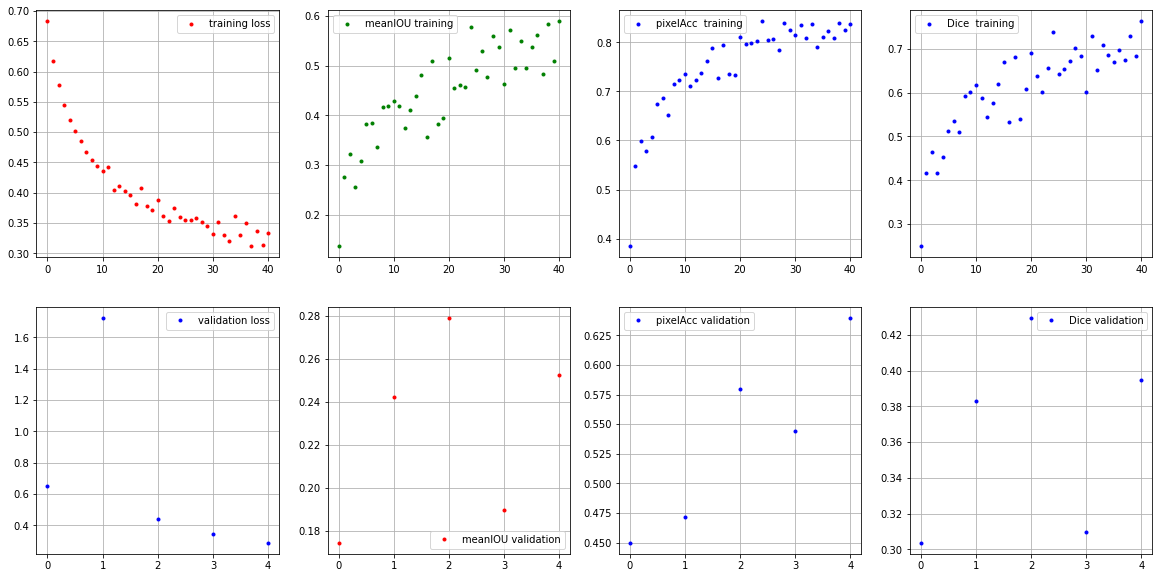

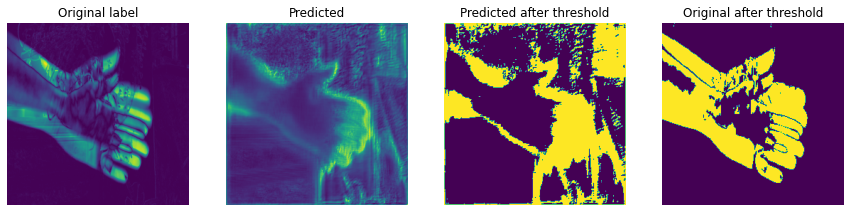

/content/gdrive/My Drive/deep_learning/Project/models/model_UNET_resnet101,Epoch:1,batch:40second_BCELOSS_print_every=700_7.3_test.pt
Epoch: 1.000000, Batch:51 loss:0.3066666126251


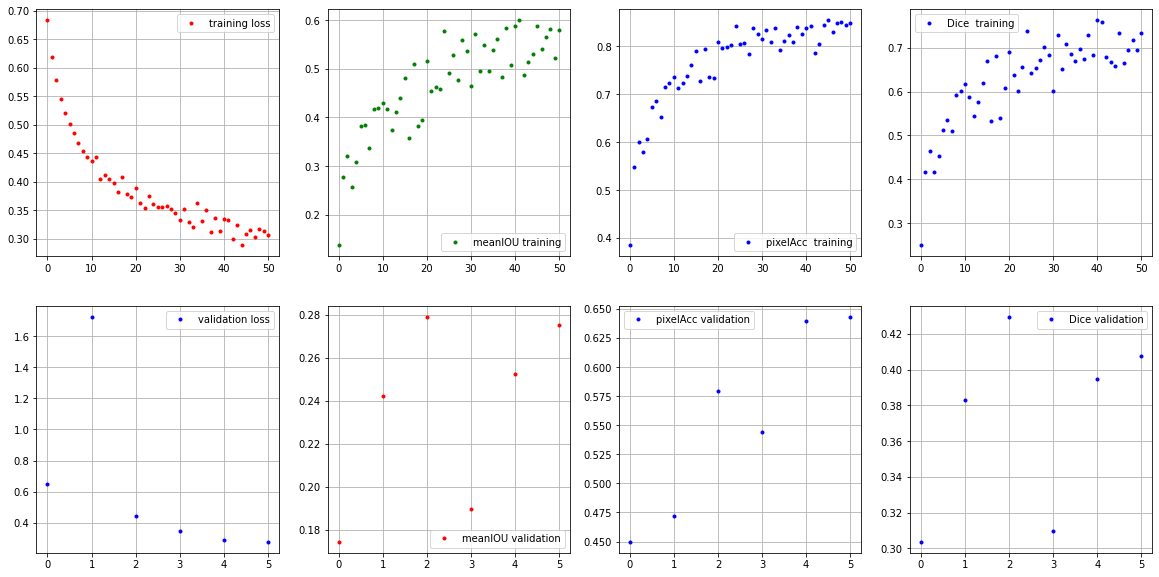

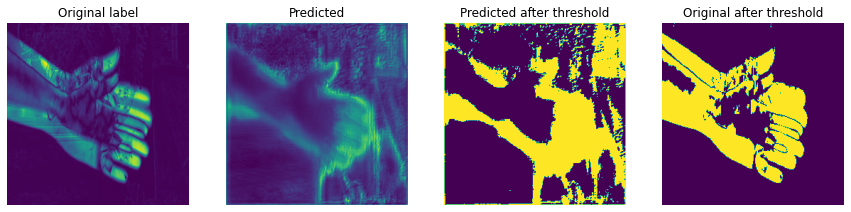

/content/gdrive/My Drive/deep_learning/Project/models/model_UNET_resnet101,Epoch:1,batch:50second_BCELOSS_print_every=700_7.3_test.pt
Epoch: 1.000000, Batch:61 loss:0.2868579030037


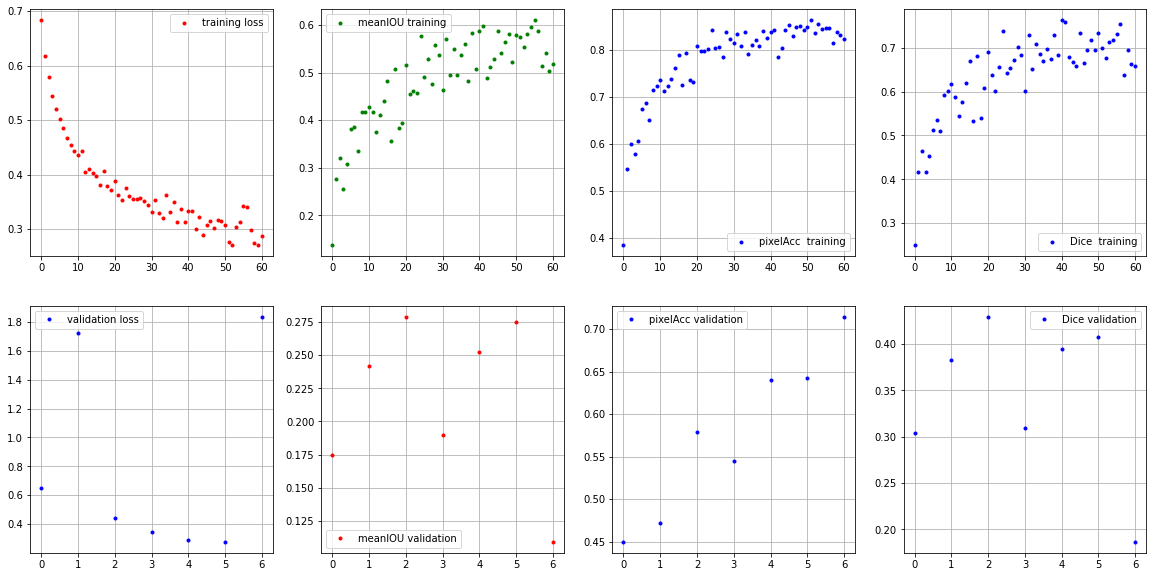

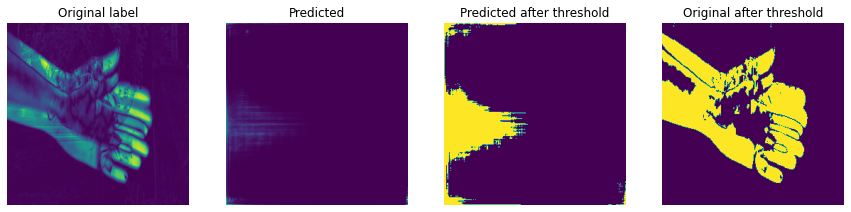

/content/gdrive/My Drive/deep_learning/Project/models/model_UNET_resnet101,Epoch:1,batch:60second_BCELOSS_print_every=700_7.3_test.pt
Epoch: 1.000000, Batch:71 loss:0.3402910828590


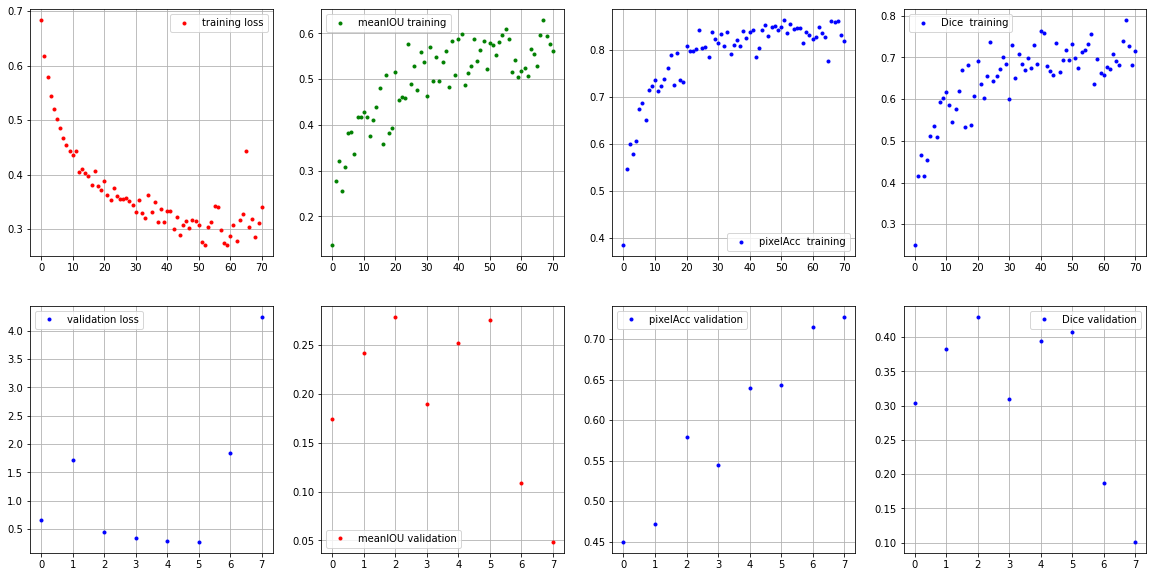

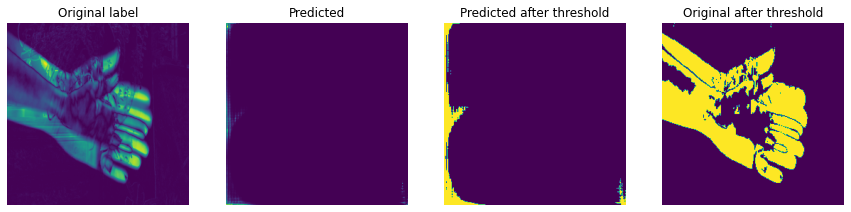

/content/gdrive/My Drive/deep_learning/Project/models/model_UNET_resnet101,Epoch:1,batch:70second_BCELOSS_print_every=700_7.3_test.pt
Epoch: 1.000000, Batch:81 loss:0.2891478240490


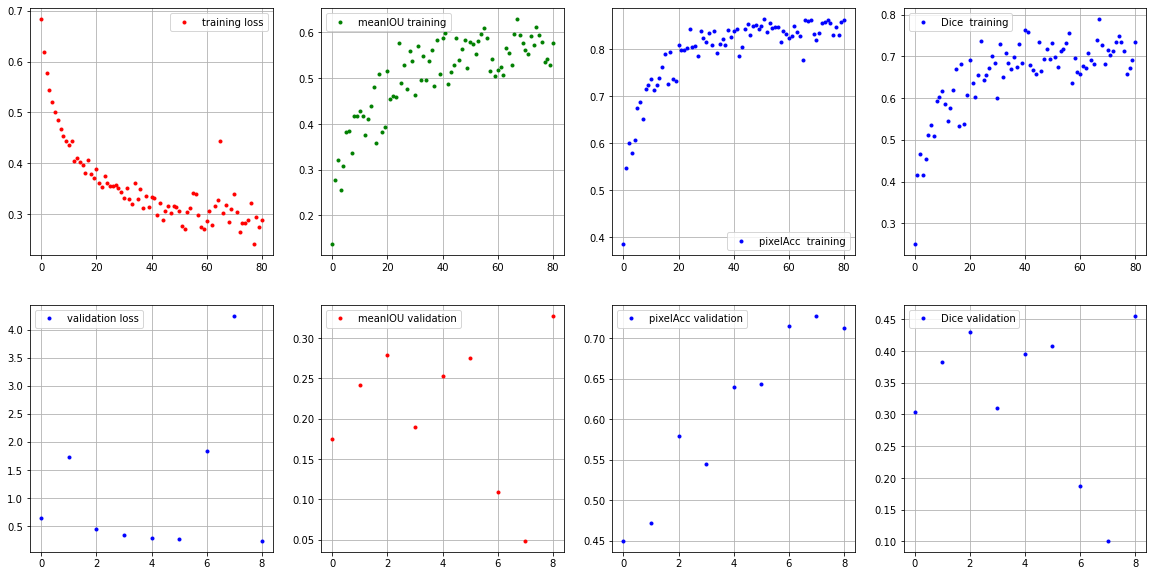

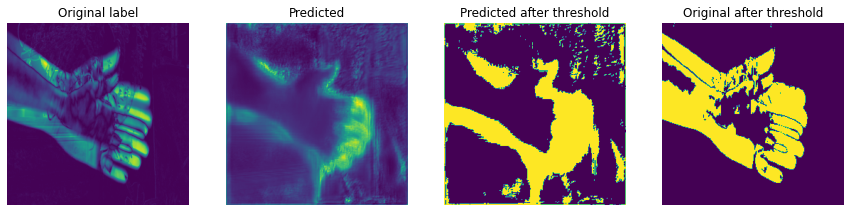

/content/gdrive/My Drive/deep_learning/Project/models/model_UNET_resnet101,Epoch:1,batch:80second_BCELOSS_print_every=700_7.3_test.pt


In [ ]:
for model_arch in models_names:
  for class_i in num_class:
    print('Numer of classes:', class_i)
    model = get_model(model_arch, class_i)
    # if GPU is available, move the model to GPU
    if use_GPU:
      model.to(dev)
      print('Using GPU')
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)
    print(f'model:{model_arch}')
    for batch_i in batchSize:
      print('Batch size is: ', batch_i)
      for diff_i in diff:
          print('Diff is:', diff_i)
          train_loader = create_loader(diff_i, class_i, batch_i, trained_on, zipped, 1)
          val_loader = create_loader(diff_i, class_i, batch_i, validation_set, zipped, 0)
          for criterion in criterions:
            print('Criterion is:', criterion)
            start = time.time()
            running_train_loss = []; meanioutrain = []; pixelacctrain = [];
            dicetrain = [];  MSEtrain = [];
            running_test_loss_arr = []; meanioutest_arr = [];
            pixelacctest_arr = []; dicetest_arr = []; 
            MSEtest_arr = []
            for epoch in range(1, n_epochs+1):              
              for i, (data, target) in enumerate(train_loader):
                torch.cuda.empty_cache()
                if i == 0:
                    print('The shape of the data:', np.shape(data))
                # move tensors to GPU if CUDA is available
                if use_GPU:
                    data, target = data.cuda().float(), target.cuda().float()
                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                if str(criterion) == 'MSELoss()':
                    loss = criterion(torch.sigmoid(output), target)
                else:
                    loss = criterion(output, target)
                output = torch.sigmoid(output)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()

                running_train_loss.append(float(loss.item()))
                meanioutrain.append(float(s.meanIOU(target, output)))
                pixelacctrain.append(float(s.pixelAcc(target, output)))
                dicetrain.append(float(s.dice_score(target, output)))
                MSEtrain.append(float(s.MSE(target, output)))
                
                if i%print_every==0: #print trainning loss and calculate validation scores
                  print('Epoch: %f, Batch:%d loss:%.13f' %(epoch, i+1, loss.item()))
                  meanioutest = []; pixelacctest = []; dicetest = [];
                  MSEtest = []; running_test_loss = [];
                  with torch.no_grad():
                      val_loss = 0
                      model.eval()
                      for j, (data, target) in enumerate(val_loader):
                          torch.cuda.empty_cache()
                          if use_GPU:
                            data, target = data.cuda().float(), target.cuda().float()
                          output = model(data)
                          if str(criterion) == 'MSELoss()':
                            loss = criterion(torch.sigmoid(output), target)
                          else:
                            loss = criterion(output, target)
                          output = torch.sigmoid(output)
                      
                          running_test_loss.append(float(loss.item()))
                          meanioutest.append(float(s.meanIOU(target, output)))
                          pixelacctest.append(float(s.pixelAcc(target, output)))
                          dicetest.append(float(s.dice_score(target, output)))
                          MSEtest.append(float(s.MSE(target, output)))
                      running_test_loss_arr.append(np.mean(running_test_loss))
                      meanioutest_arr.append(np.mean(meanioutest))
                      pixelacctest_arr.append(np.mean(pixelacctest))
                      dicetest_arr.append(np.mean(dicetest))
                      MSEtest_arr.append(np.mean(MSEtest))

                      plot_graphs(model_arch, epoch, running_train_loss, running_test_loss_arr, 
                                  meanioutrain, meanioutest_arr, 
                                  pixelacctrain, pixelacctest_arr, 
                                  dicetrain, dicetest_arr)
                      plot_segmentation_comparison(target, output)
                      checkpoint = {'state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'Training Loss': running_train_loss,
                                    'Validation Loss':running_test_loss_arr,
                                    'MeanIOU train':meanioutrain,
                                    'PixelAcc train':pixelacctrain,
                                    'Dice train': dicetrain,
                                    'MeanIOU test':meanioutest_arr,
                                    'PixelAcc test':pixelacctest_arr,
                                    'Dice test': dicetest_arr,
                                    'MSE train': MSEtrain,
                                    'MSE test': MSEtest_arr} 
                      model_name = path_save_model+model_arch+',Epoch:'+str(epoch)+ ',batch:'+ str(i)+'second_BCELOSS_print_every=700_7.3_test.pt'
                      print(model_name)
                      torch.save(checkpoint, model_name)    

                  
                      model.train()
              lr_scheduler.step()
              print('Epoch %d, Train loss: %.16f Val loss: %.16f' % (epoch, running_train_loss[-1], running_test_loss_arr[-1]))         
      

              end = time.time()
              print('Epoch training time:', end - start)

              add_to_csv(model_arch, model_name, pretrained, trained_layers,
                          diff_i,epoch,	batch_i, class_i, optimizer_name, 
                          criterion, 1, str(trained_on), 
                          MSEtrain[-1], running_train_loss[-1], meanioutrain[-1],
                          pixelacctrain[-1], dicetrain[-1],
                          running_test_loss_arr[-1], meanioutest_arr[-1],
                          pixelacctest_arr[-1], dicetest_arr[-1], 
                          MSEtest_arr[-1], end - start)

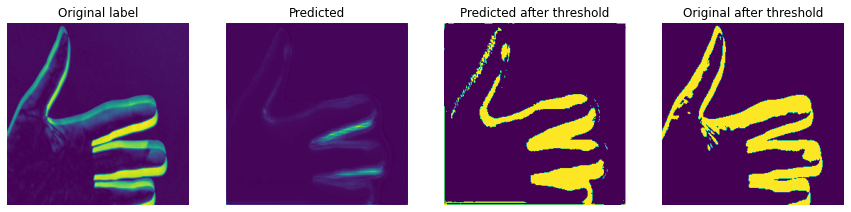

In [ ]:
plot_segmentation_comparison(target, output)